# Imports

In [2]:
import pandas as pd
import os
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import DBSCAN
import torch
import torch.nn as nn
import torch.nn.functional as f
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split

# Import dataset

In [3]:
charpy_columns = ["Charpy impact toughness (J)", "Charpy temperature (deg C)"]
stress_columns = ["Yield strength (MPa)", "Ultimate tensile strength (MPa)", "Elongation (%)", "Reduction of Area (%)"]
target_columns = charpy_columns + stress_columns

data = pd.read_csv('data.csv')
X = data.drop(target_columns,axis=1)
y = data[target_columns]

In [4]:
X_supervised = X[y['Yield strength (MPa)'].notna()]
y_supervised = y[y['Yield strength (MPa)'].notna()]

In [5]:
class MLP(nn.Module):
    def __init__(self, size_vector):
        super(MLP, self).__init__()
        self.layers = nn.ModuleList()
        for i in range(len(size_vector)-1):
            self.layers.append(nn.Linear(size_vector[i],size_vector[i+1]))
            self.layers.append(nn.Tanh())
        self.layers.pop(-1)


    def forward(self,x):
        for layer in self.layers:
            x = layer(x)
        return x

Epoch [5/1000], Loss: 0.9669
Epoch [10/1000], Loss: 0.0070
Epoch [15/1000], Loss: 0.6283
Epoch [20/1000], Loss: 0.0257
Epoch [25/1000], Loss: 1.0810
Epoch [30/1000], Loss: 0.2123
Epoch [35/1000], Loss: 0.9457
Epoch [40/1000], Loss: 0.1624
Epoch [45/1000], Loss: 0.5252
Epoch [50/1000], Loss: 1.1499
Epoch [55/1000], Loss: 1.3092
Epoch [60/1000], Loss: 0.0898
Epoch [65/1000], Loss: 0.5342
Epoch [70/1000], Loss: 0.2002
Epoch [75/1000], Loss: 0.3663
Epoch [80/1000], Loss: 0.2952
Epoch [85/1000], Loss: 0.0774
Epoch [90/1000], Loss: 0.6249
Epoch [95/1000], Loss: 0.2414
Epoch [100/1000], Loss: 1.3601
Epoch [105/1000], Loss: 0.0285
Epoch [110/1000], Loss: 0.1512
Epoch [115/1000], Loss: 0.3557
Epoch [120/1000], Loss: 0.2323
Epoch [125/1000], Loss: 0.1809
Epoch [130/1000], Loss: 0.0646
Epoch [135/1000], Loss: 0.2646
Epoch [140/1000], Loss: 0.4059
Epoch [145/1000], Loss: 1.4110
Epoch [150/1000], Loss: 0.0157
Epoch [155/1000], Loss: 0.2295
Epoch [160/1000], Loss: 0.5209
Epoch [165/1000], Loss: 0.26

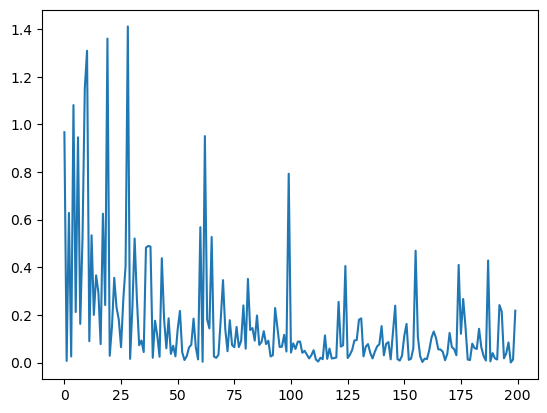

In [49]:
X_tensor = torch.tensor(X_supervised.values, dtype=torch.float32)
y_tensor = torch.tensor(y_supervised['Yield strength (MPa)'].values, dtype=torch.float32)
dataset = TensorDataset(X_tensor,y_tensor)

train_size = int(0.6 * len(dataset))  # 70% for training
val_size = int(0.2 * len(dataset))    # 15% for validation
test_size = len(dataset) - train_size - val_size  # Remaining for test

# Step 2: Split the dataset
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

model = MLP([len(X.columns),8,1])
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(),lr=0.0001)

num_epochs = 1000

training_loss = []
val_loss_vector = []

model.eval()
validation_loss = 0
with torch.no_grad():
    for ite, (val_X,val_y) in enumerate(val_loader):
        val_outputs = model(val_X)
        validation_loss += torch.mean(f.mse_loss(val_outputs.reshape([-1]),val_y.reshape([-1])))

    val_loss_vector.append(validation_loss/ite)

model.train()

for epoch in range(num_epochs):
    for iteration, (batch_X, batch_y) in enumerate(train_loader):

        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs.reshape([-1]), batch_y.reshape([-1]))
        loss.backward()
        optimizer.step()

    if (epoch+1) % 5 == 0:
        training_loss.append(loss.item())
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {training_loss[-1]:.4f}')

        model.eval()
        validation_loss = 0
        with torch.no_grad():
            for ite, (val_X,val_y) in enumerate(val_loader):
                val_outputs = model(val_X)
                validation_loss += torch.mean(f.mse_loss(val_outputs.reshape([-1]),val_y.reshape([-1])))

            val_loss_vector.append(validation_loss/(ite+1))

        model.train()

plt.plot(training_loss)
#plt.plot(range(len(val_loss_vector)),val_loss_vector)
plt.show()

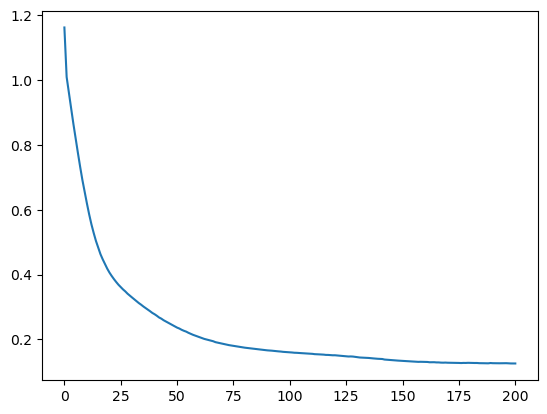

Minimal validation loss: 0.12585309147834778


In [50]:
plt.plot(range(len(val_loss_vector)),val_loss_vector)
plt.show()
print(f"Minimal validation loss: {min(val_loss_vector)}")

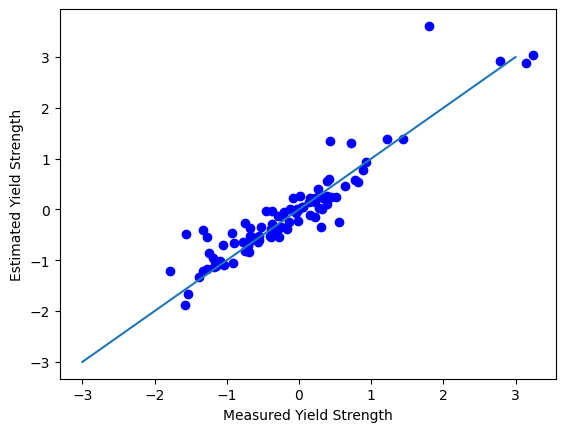

In [51]:

model.eval()
with torch.no_grad():
    targets = val_dataset[:][1]
    X_valid = val_dataset[:][0]
    y_model = model(X_valid)
    plt.plot(targets,y_model,'ob')
    plt.plot(range(-3,4),range(-3,4))
    plt.xlabel("Measured Yield Strength")
    plt.ylabel("Estimated Yield Strength")
    plt.show()

model.train();

# KNN Regression

In [68]:
training_data = torch.utils.data.ConcatDataset([train_dataset, val_dataset])
data_list = []
target_list = []
for data, target in training_data:
    data_list.append(data.numpy())
    target_list.append(target.numpy())

X_training = np.array(data_list)
y_training = np.array(target_list)

100%|██████████| 14/14 [00:06<00:00,  2.25it/s]


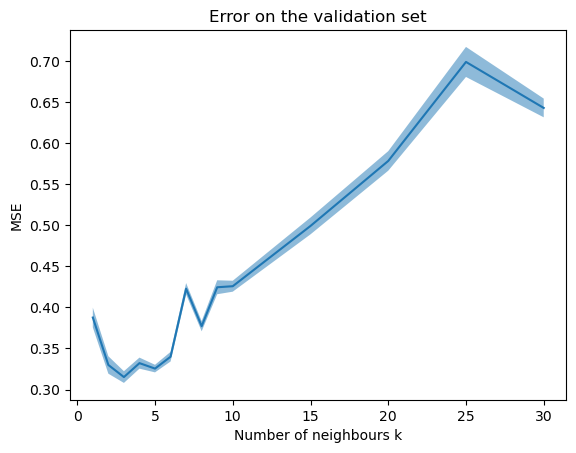

Minimal validation loss: 0.31513968110084534 for n_neib = 3


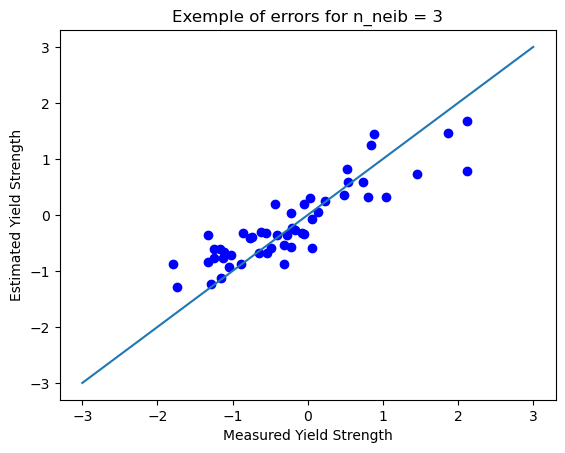

In [91]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm
neib_vect = [1,2,3,4,5,6,7,8,9,10,15,20,25,30]
mean_error = []
var_error = []
train_mse = []
for n_neib in tqdm(neib_vect):
    current_errors = []
    for i in range(50):
        X_train, X_val, y_train, y_val = train_test_split(X_training, y_training, test_size=0.1415)

        knn = KNeighborsRegressor(n_neighbors=n_neib)

        knn.fit(X_train, y_train)

        y_pred = knn.predict(X_val)

        train_mse.append(mean_squared_error(y_train,knn.predict(X_train)))
        mse = mean_squared_error(y_val, y_pred)
        current_errors.append(mse)
    var_error.append(np.var(current_errors))
    mean_error.append(np.mean(current_errors))

var_error = np.array(var_error)
mean_error = np.array(mean_error)

plt.plot(neib_vect,mean_error)
plt.fill_between(neib_vect,mean_error-0.5*np.array(var_error),mean_error+0.5*var_error, alpha=0.5)
plt.title("Error on the validation set")
plt.ylabel("MSE")
plt.xlabel("Number of neighbours k")
plt.show()
best_hp = neib_vect[np.argmin(mean_error)]
print(f"Minimal validation loss: {min(mean_error)} for n_neib = {best_hp}")

best_knn = KNeighborsRegressor(n_neighbors=best_hp)
best_knn.fit(X_train,y_train)
plt.plot(y_val,best_knn.predict(X_val),'ob')
plt.plot(range(-3,4),range(-3,4))
plt.title(f"Exemple of errors for n_neib = {best_hp}")
plt.xlabel("Measured Yield Strength")
plt.ylabel(f"Estimated Yield Strength")
plt.show()


# Decision Trees

100%|██████████| 14/14 [00:04<00:00,  2.87it/s]


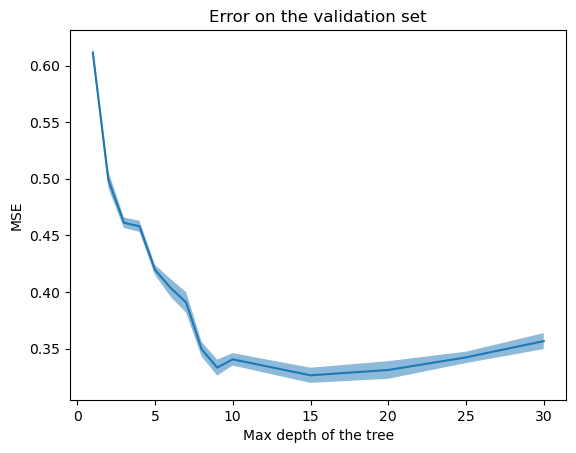

Minimal validation loss: 0.3263426869245437 for max depth = 15


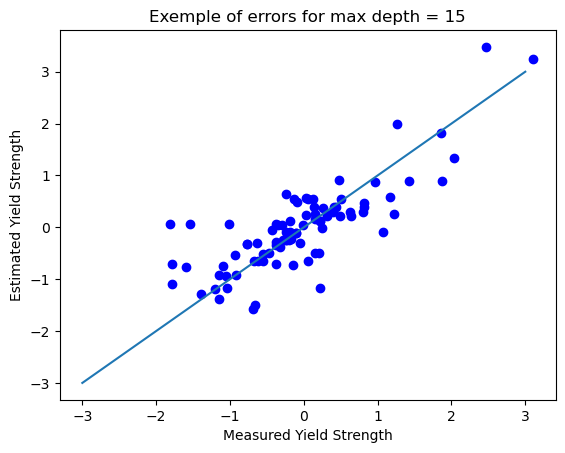

In [88]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm
depth_vect = [1,2,3,4,5,6,7,8,9,10,15,20,25,30]
mean_error = []
var_error = []
train_mse = []
for depth in tqdm(depth_vect):
    current_errors = []
    for i in range(50):
        X_train, X_val, y_train, y_val = train_test_split(X_training, y_training, test_size=0.1415)

        dt = DecisionTreeRegressor(max_depth=depth)

        dt.fit(X_train, y_train)

        y_pred = dt.predict(X_val)

        train_mse.append(mean_squared_error(y_train,dt.predict(X_train)))
        mse = mean_squared_error(y_val, y_pred)
        current_errors.append(mse)
    var_error.append(np.var(current_errors))
    mean_error.append(np.mean(current_errors))

var_error = np.array(var_error)
mean_error = np.array(mean_error)

plt.plot(depth_vect,mean_error)
plt.fill_between(depth_vect,mean_error-0.5*np.array(var_error),mean_error+0.5*var_error,alpha=0.5,)
plt.title("Error on the validation set")
plt.ylabel("MSE")
plt.xlabel("Max depth of the tree")
plt.show()
best_hp = depth_vect[np.argmin(mean_error)]
print(f"Minimal validation loss: {min(mean_error)} for max depth = {best_hp}")

best_dt = DecisionTreeRegressor(max_depth=best_hp)
best_dt.fit(X_train,y_train)
plt.plot(y_val,best_dt.predict(X_val),'ob')
plt.plot(range(-3,4),range(-3,4))
plt.title(f"Exemple of errors for max depth = {best_hp}")
plt.xlabel("Measured Yield Strength")
plt.ylabel(f"Estimated Yield Strength")
plt.show()


# Random Forest

100%|██████████| 12/12 [01:10<00:00,  5.90s/it]


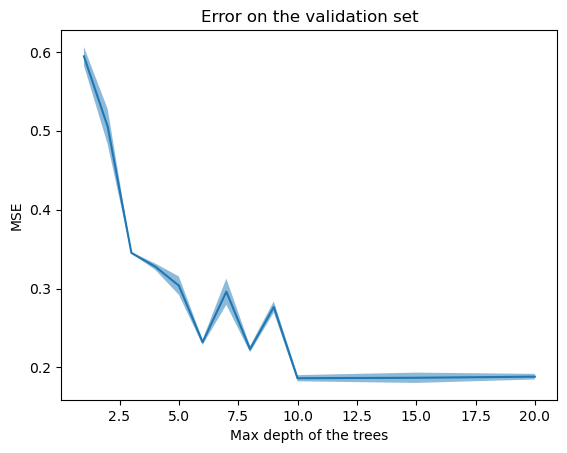

Minimal validation loss: 0.18632397115304775 for max depth = 10


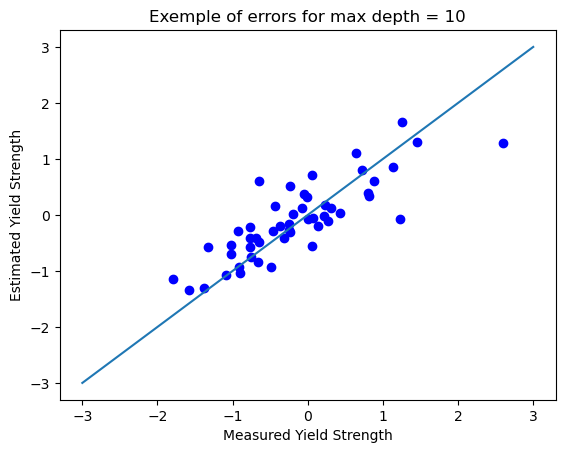

In [101]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm
depth_vect = [1,2,3,4,5,6,7,8,9,10,15,20]
mean_error = []
var_error = []
train_mse = []
for depth in tqdm(depth_vect):
    current_errors = []
    for i in range(10):
        X_train, X_val, y_train, y_val = train_test_split(X_training, y_training, test_size=0.1415)

        rf = RandomForestRegressor(max_depth=depth)

        rf.fit(X_train, y_train)

        y_pred = rf.predict(X_val)

        train_mse.append(mean_squared_error(y_train,rf.predict(X_train)))
        mse = mean_squared_error(y_val, y_pred)
        current_errors.append(mse)
    var_error.append(np.var(current_errors))
    mean_error.append(np.mean(current_errors))

var_error = np.array(var_error)
mean_error = np.array(mean_error)

plt.plot(depth_vect,mean_error)
plt.fill_between(depth_vect,mean_error-0.5*np.array(var_error),mean_error+0.5*var_error,alpha=0.5,)
plt.title("Error on the validation set")
plt.ylabel("MSE")
plt.xlabel("Max depth of the trees")
plt.show()
best_hp = depth_vect[np.argmin(mean_error)]
print(f"Minimal validation loss: {min(mean_error)} for max depth = {best_hp}")

best_rf = RandomForestRegressor(max_depth=best_hp)
best_rf.fit(X_train,y_train)
plt.plot(y_val,best_rf.predict(X_val),'ob')
plt.plot(range(-3,4),range(-3,4))
plt.title(f"Exemple of errors for max depth = {best_hp}")
plt.xlabel("Measured Yield Strength")
plt.ylabel(f"Estimated Yield Strength")
plt.show()

# SVM Regression

100%|██████████| 42/42 [00:49<00:00,  1.18s/it]


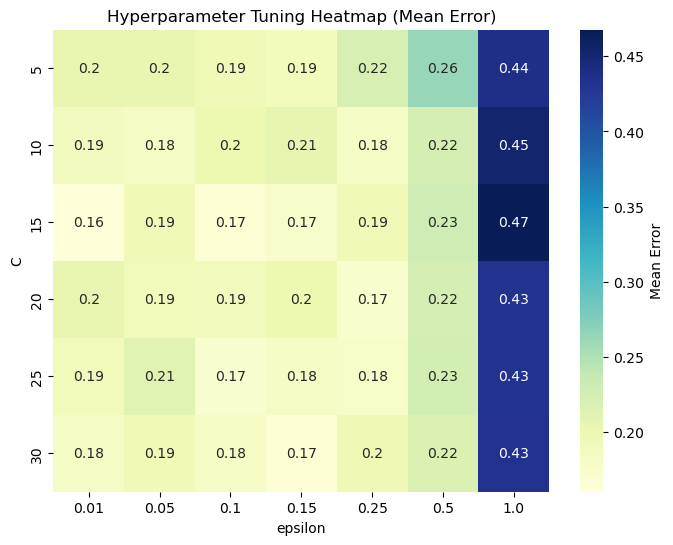

Minimal validation loss: 0.16029713322058875 for C = 15 and epsilon = 0.01


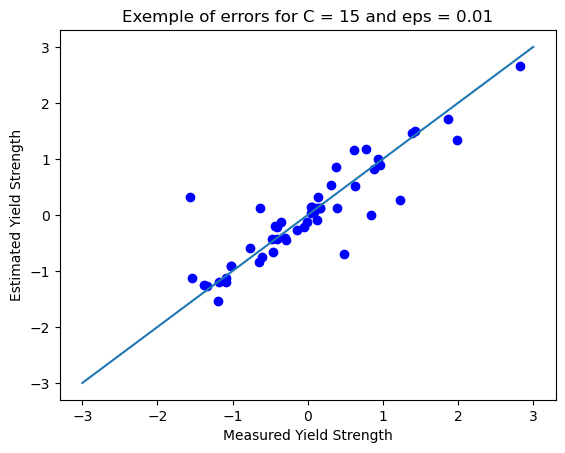

In [117]:
from sklearn.svm import SVR
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import seaborn as sns

mean_error = []
var_error = []
train_mse = []

param_grid = {
    'C': [5, 10, 15, 20,25,30],
    'epsilon': [0.01,0.05, 0.1,0.15,0.25,0.5, 1],
}

for params in tqdm(ParameterGrid(param_grid)):
    current_errors = []
    for i in range(50):
        X_train, X_val, y_train, y_val = train_test_split(X_training, y_training, test_size=0.1415)

        sv = SVR(C=params['C'],epsilon=params['epsilon'],kernel='rbf')

        sv.fit(X_train, y_train)

        y_pred = sv.predict(X_val)

        train_mse.append(mean_squared_error(y_train,sv.predict(X_train)))
        mse = mean_squared_error(y_val, y_pred)
        current_errors.append(mse)
    var_error.append(np.var(current_errors))
    mean_error.append(np.mean(current_errors))

var_error = np.array(var_error)
mean_error = np.array(mean_error)

mean_error_matrix = mean_error.reshape(len(param_grid['C']),len(param_grid['epsilon']))

heatmap_data = pd.DataFrame(mean_error_matrix, index=param_grid['C'], columns=param_grid['epsilon'])

plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, cmap="YlGnBu", cbar_kws={'label': 'Mean Error'})
plt.title('Hyperparameter Tuning Heatmap (Mean Error)')
plt.xlabel('epsilon')
plt.ylabel('C')
plt.show()

min_error_index = np.unravel_index(np.argmin(mean_error_matrix, axis=None), mean_error_matrix.shape)
# Retrieve the best hyperparameters
best_C = param_grid['C'][min_error_index[0]]  # Row index corresponds to C values
best_epsilon = param_grid['epsilon'][min_error_index[1]]

print(f'Minimal validation loss: {np.min(mean_error_matrix,axis=None)} for C = {best_C} and epsilon = {best_epsilon}')

best_sv = SVR(C=best_C,epsilon=best_epsilon)
best_sv.fit(X_train,y_train)
plt.plot(y_val,best_sv.predict(X_val),'ob')
plt.plot(range(-3,4),range(-3,4))
plt.title(f"Exemple of errors for C = {best_C} and eps = {best_epsilon}")
plt.xlabel("Measured Yield Strength")
plt.ylabel(f"Estimated Yield Strength")
plt.show()


# Random forest in Semi Supervised mode

In [105]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm

X_unlabeled = np.array(X[y['Yield strength (MPa)'].isna()])
y_unlabeled = np.array(y[y['Yield strength (MPa)'].isna()])

depth_vect = [1,2,3,4,5,6,7,8,9,10,15,20]
mean_error = []
var_error = []
train_mse = []
for depth in tqdm(depth_vect):
    current_errors = []
    for i in range(10):
        X_train, X_val, y_train, y_val = train_test_split(X_training, y_training, test_size=0.1415)

        rf = RandomForestRegressor(max_depth=depth)

        rf.fit(X_train, y_train)

        pseudo_labels = rf.predict(X_unlabeled)

        max_iterations = 10
        confidence_threshold = 0.2

        for iteration in range(max_iterations):
            preds_per_tree = np.array([tree.predict(X_unlabeled) for tree in rf.estimators_])
            preds_std = np.std(preds_per_tree, axis=0)

            confident_mask = preds_std < confidence_threshold
            X_confident = X_unlabeled[confident_mask]
            y_confident = pseudo_labels[confident_mask]

            if len(X_confident) == 0:
                print(f"No confident pseudo-labels found in iteration {iteration}. Stopping.")
                break

            X_train = np.vstack([X_train, X_confident])
            y_train = np.concatenate([y_train, y_confident])

            rf.fit(X_train,y_train)
        
        y_pred = rf.predict(X_val)
        train_mse.append(mean_squared_error(y_train,rf.predict(X_train)))
        mse = mean_squared_error(y_val, y_pred)
        current_errors.append(mse)
    var_error.append(np.var(current_errors))
    mean_error.append(np.mean(current_errors))

var_error = np.array(var_error)
mean_error = np.array(mean_error)

plt.plot(depth_vect,mean_error)
plt.fill_between(depth_vect,mean_error-0.5*np.array(var_error),mean_error+0.5*var_error,alpha=0.5,)
plt.title("Error on the validation set")
plt.ylabel("MSE")
plt.xlabel("Max depth of the trees")
plt.show()
best_hp = depth_vect[np.argmin(mean_error)]
print(f"Minimal validation loss: {min(mean_error)} for max depth = {best_hp}")

best_rf = RandomForestRegressor(max_depth=best_hp)
best_rf.fit(X_train,y_train)
plt.plot(y_val,best_rf.predict(X_val),'ob')
plt.plot(range(-3,4),range(-3,4))
plt.title(f"Exemple of errors for max depth = {best_hp}")
plt.xlabel("Measured Yield Strength")
plt.ylabel(f"Estimated Yield Strength")
plt.show()

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:19<?, ?it/s]


KeyboardInterrupt: 

In [111]:
X_test = np.array(test_dataset[:][0])
y_test = np.array(test_dataset[:][1])

y_pred = best_sv.predict(X_test)
mean_squared_error(y_test,y_pred)


0.13244870477162993

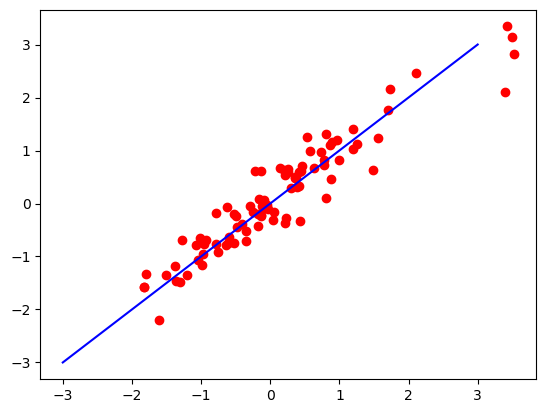

In [113]:
plt.plot(y_test,y_pred,'or')
plt.plot(range(-3,4),range(-3,4),'b')